In [2]:
import pandas as pd 
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')


D* = Delinquency variables S = Spend variables P_ = Payment variables B* = Balance variables R* = Risk variables with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [3]:
start = time.time()

df_path = "./train.parquet"
target_path = "./train_labels.csv"
test_path = "./test.parquet"
sample_path = "./sample_submission.csv"


Read time of dataset and archives

In [4]:
df = pd.read_parquet(path=df_path)
end1 = time.time() - start

test = pd.read_parquet(path=test_path)
end2 = time.time() - start - end1

target = pd.read_csv(target_path)
end3 = time.time() - start - end1 - end2

sample = pd.read_csv(sample_path)
end4 = time.time() - start - end1 - end2 - end3
print(f'time train: {end1}')
print(f'time test: {end2}')
print(f'time target: {end3}')
print(f'time sample: {end4}')
print("done")


time train: 2.1183269023895264
time test: 4.888932228088379
time target: 0.39914965629577637
time sample: 0.5427792072296143
done


Group by customer

In [5]:
start = time.time()
agg_dict = {}
obj_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
not_obj = [i for i in df.columns if (i not in obj_col)]
not_obj.remove("customer_ID")
not_obj.remove("S_2")

df_grouped = df.groupby("customer_ID").tail(1)
test_grouped = test.groupby("customer_ID").tail(1)
end = time.time()-start
print(end)


4.162052154541016


Grouped infos

In [6]:
df_grouped.info()


<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 12 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 218.8+ MB


In [7]:
test_grouped.info()


<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 8 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(10), int8(85), object(2)
memory usage: 441.8+ MB


Identifies Nan's columns or missing values and calculates the count of train and test separately and combines

In [8]:
def get_del_col(df, call_rows):
    del_col = []
    for col in df.columns:
        count = df[col].isna().sum()
        if count > call_rows*0.5:
            del_col.append(col)
    return del_col

train_del_col = get_del_col(df, 458913)
test_del_col = get_del_col(test, 924621)
del_col = list(set(train_del_col) | set(test_del_col))
del_col.extend(["S_2"])
print(f'del_col_for_train : {len(train_del_col)}')
print(f'del_col_for_test : {len(test_del_col)}')
print(f'size of del_col : {len(del_col)}')


del_col_for_train : 27
del_col_for_test : 28
size of del_col : 30


Drop columns identified at last step

In [9]:
df_reduced = df_grouped.drop(columns = del_col)
test_reduced = test_grouped.drop(columns = del_col)


Defines the categorical columns, filter columns that are also in del_col and one hot enconding to dataset reduced  

In [10]:
obj_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
obj_col = [i for i in obj_col if i not in del_col]


df_hot = pd.get_dummies(data=df_reduced, columns = obj_col)
test_hot = pd.get_dummies(data=test_reduced, columns = obj_col)


df_hot.info()
test_hot.info()


<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 12 to 5531450
Columns: 199 entries, customer_ID to D_68_6
dtypes: bool(50), float32(64), int16(9), int8(75), object(1)
memory usage: 181.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 8 to 11363761
Columns: 199 entries, customer_ID to D_68_6
dtypes: bool(50), float32(64), int16(10), int8(74), object(1)
memory usage: 366.8+ MB


fill the missing value that not deleted with forward fill, values are replaced with the preceding non-missing value in the same column

In [11]:
df_hot.ffill(inplace=True)
df_hot.ffill(inplace=True)
df_hot.isna().sum().sum()

test_hot.ffill(inplace=True)
test_hot.ffill(inplace=True)
test_hot.isna().sum().sum()


np.int64(0)

Set customerId to index in test and train dataset

In [12]:
df_hotter = df_hot.set_index("customer_ID")
test_hotter = test_hot.set_index("customer_ID")


Get bool cols and iterates of each to convert to int type 

In [13]:
bool_col = df_hotter.select_dtypes("bool").columns
for col in bool_col:
    df_hotter[col] = df_hotter[col].astype("int8")
    test_hotter[col] = test_hotter[col].astype("int8")


df_hotter.info()
test_hotter.info()


<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 198 entries, P_2 to D_68_6
dtypes: float32(64), int16(9), int8(125)
memory usage: 178.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 198 entries, P_2 to D_68_6
dtypes: float32(64), int16(10), int8(124)
memory usage: 359.8+ MB


Get head of train to validate the values

In [14]:
df_hotter.head()


,P_2,D_39,B_1,B_2,R_1,D_41,B_3,D_44,B_4,D_45,...,D_64_3,D_66_-1,D_66_1,D_68_-1,D_68_1,D_68_2,D_68_3,D_68_4,D_68_5,D_68_6
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0,0.009382,1.007647,0.006104,0.0,0.007174,0,5,0.740102,...,0,1,0,0,0,0,0,0,0,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,6,0.034684,1.004028,0.006911,0.0,0.005068,0,1,0.266275,...,0,1,0,0,0,0,0,0,0,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,0,0.004284,0.812649,0.006450,0.0,0.007196,0,2,0.251598,...,0,1,0,0,0,0,0,0,0,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,0,0.012564,1.006183,0.007829,0.0,0.009937,0,0,0.085103,...,0,1,0,0,0,0,1,0,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,0,0.007679,0.815746,0.001247,0.0,0.005528,0,21,0.069952,...,0,0,1,0,0,0,0,0,0,1


# This line splits the df_hotter DataFrame and the target["target"] Series into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility with random_state=31.

Usar random_state=31 garante que a divisão dos dados em conjuntos de treinamento e teste seja reprodutível. Isso significa que toda vez que você executar o código com os mesmos dados e random_state. O valor específico 31 é arbitrário e pode ser qualquer número inteiro; ele é apenas uma semente para o gerador de números aleatórios.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_hotter,target["target"],test_size=0.2,random_state=31)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(367130, 198)
(367130,)
(91783, 198)
(91783,)


# Defines many algorithms to get the best to predict the dataset

## xgboost
It uses a boosting approach where each tree is built sequentially to correct the errors of the previous predictions

## decision tree
It partitions the feature space into rectangular regions and predicts a value for each region based on data conditions

## Light Gradient Boosting Machine
Similar to XGBoost, but uses a "leaf-wise" tree building strategy instead of "level-wise", potentially leading to faster training

In [16]:

xgb = XGBClassifier(max_depth = 1, n_estimators = 100, learning_rate = 1, random_state = 31)
dt = DecisionTreeClassifier(max_depth = 1, random_state = 31)
lgbm = LGBMClassifier(force_col_wise=True, max_depth = 1, n_estimators = 100, learning_rate = 1, random_state = 31)
vote_hard = VotingClassifier(estimators = [('xgb', xgb), ('dt', dt), ('lgbm', lgbm)], voting = 'hard')
vote_soft = VotingClassifier(estimators = [('xgb', xgb), ('dt', dt), ('lgbm', lgbm)], voting = 'soft')


Measure the time required to train three different classifiers

In [17]:
start = time.time()

xgb.fit(X_train, y_train)
dt.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
end = time.time()- start
print(end)


[LightGBM] [Info] Number of positive: 95144, number of negative: 271986
[LightGBM] [Info] Total Bins 18252
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259156 -> initscore=-1.050359
[LightGBM] [Info] Start training from score -1.050359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

The time to define vote_hard and vote_soft to train the dataset

In [18]:
start = time.time()
vote_hard.fit(X_train, y_train)
vote_soft.fit(X_train, y_train)

end = time.time()- start
print(end)


[LightGBM] [Info] Number of positive: 95144, number of negative: 271986
[LightGBM] [Info] Total Bins 18252
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259156 -> initscore=-1.050359
[LightGBM] [Info] Start training from score -1.050359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Assigns the predictions made by different classifiers (XGBoost, Decision Tree, LightGBM, and two voting classifiers) to separate variables and then stores them in a list for further analysis or comparison:



In [19]:
y_pred_xgb = xgb.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)
y_pred_vote_hard = vote_hard.predict(X_test)
y_pred_vote_soft = vote_soft.predict(X_test)

y_preds = [y_pred_xgb,
           y_pred_dt,
           y_pred_lgbm,
           y_pred_vote_hard,
           y_pred_vote_soft]

print(y_preds)


[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]


Print the accuracy score for each model's predictions stored in y_preds relative to the true labels y_test. Adjust y_test and y_preds according to your actual data and predictions for accurate evaluation.

In [20]:
models = ["XGB", "DT", "LGBM", "VOTE HARD", "VOTE SOFT"]
accuracies = []

for i, pred in enumerate(y_preds):
    accuracy = accuracy_score(y_test, pred)
    accuracy = accuracy * 100
    accuracies.append((models[i], accuracy))

accuracies_sorted = sorted(accuracies, key=lambda x: x[1], reverse=True)

for model, acc in accuracies_sorted:
    print(f"{model}: {acc:.2f}%")


VOTE HARD: 89.59%
LGBM: 89.55%
XGB: 89.51%
VOTE SOFT: 89.22%
DT: 84.29%


Predict with all models to analyze

In [21]:
y_pred_goal_vote_hard = vote_hard.predict(test_hotter)
y_pred_goal_lgbm = lgbm.predict(test_hotter)
y_pred_goal_xgb = xgb.predict(test_hotter)
y_pred_goal_vote_soft = vote_soft.predict(test_hotter)
y_pred_goal_dt = dt.predict(test_hotter)

Inserts the results of the file prediction into the "submission + model.csv" file

In [22]:
sample["prediction_hard"] = y_pred_goal_vote_hard
sub_df_hard = sample[['customer_ID', 'prediction_hard']].copy()
sub_df_hard.to_csv('submission-vote-hard.csv', index=False)

sample["prediction_lgbm"] = y_pred_goal_lgbm
sub_df_lgbm = sample[['customer_ID', 'prediction_lgbm']].copy()
sub_df_lgbm.to_csv('submission-vote-lgbm.csv', index=False)

sample["prediction_dt"] = y_pred_goal_dt
sub_df_dt = sample[['customer_ID', 'prediction_dt']].copy()
sub_df_dt.to_csv('submission-vote-dt.csv', index=False)

sample["prediction_vote_xgb"] = y_pred_goal_xgb
sub_df_xgb = sample[['customer_ID', 'prediction_vote_xgb']].copy()
sub_df_xgb.to_csv('submission-vote-xgb.csv', index=False)

sample["prediction_soft"] = y_pred_goal_vote_soft
sub_df_soft = sample[['customer_ID', 'prediction_soft']].copy()
sub_df_soft.to_csv('submission-vote-soft.csv', index=False)

Now, let's analyze the result

In [23]:
submission_hard = "./submission-vote-hard.csv"
submission_dt = "./submission-vote-dt.csv"
submission_lgbm = "./submission-vote-lgbm.csv"
submission_soft = "./submission-vote-soft.csv"
submission_xgb = "./submission-vote-xgb.csv"

dt_submission_hard = pd.read_csv(submission_hard)
dt_submission_dt = pd.read_csv(submission_dt)
dt_submission_lgbm = pd.read_csv(submission_lgbm)
dt_submission_soft = pd.read_csv(submission_soft)
dt_submission_xgb = pd.read_csv(submission_xgb)

df_submission_hard_grouped = dt_submission_hard.groupby("customer_ID").tail(1)
df_submission_dt_grouped = dt_submission_dt.groupby("customer_ID").tail(1)
df_submission_lgbm_grouped = dt_submission_lgbm.groupby("customer_ID").tail(1)
df_submission_soft_grouped = dt_submission_soft.groupby("customer_ID").tail(1)
df_submission_xgb_grouped = dt_submission_xgb.groupby("customer_ID").tail(1)

Graphs and counts of prediction

In [24]:
import matplotlib.ticker as ticker
count_hard_1 = df_submission_hard_grouped['prediction_hard'].sum()
count_hard_0 = len(df_submission_hard_grouped) - count_hard_1

count_dt_1 = df_submission_dt_grouped['prediction_dt'].sum()
count_dt_0 = len(df_submission_dt_grouped) - count_dt_1

count_lgbm_1 = df_submission_lgbm_grouped['prediction_lgbm'].sum()
count_lgbm_0 = len(df_submission_lgbm_grouped) - count_lgbm_1

count_soft_1 = df_submission_soft_grouped['prediction_soft'].sum()
count_soft_0 = len(df_submission_soft_grouped) - count_soft_1

count_xgb_1 = df_submission_xgb_grouped['prediction_vote_xgb'].sum()
count_xgb_0 = len(df_submission_xgb_grouped) - count_xgb_1

models = ['VOTE HARD', 'DT', 'LGBM', 'VOTE SOFT', 'XGB']
counts_1 = [count_hard_1, count_dt_1, count_lgbm_1, count_soft_1, count_xgb_1]
counts_0 = [count_hard_0, count_dt_0, count_lgbm_0, count_soft_0, count_xgb_0]


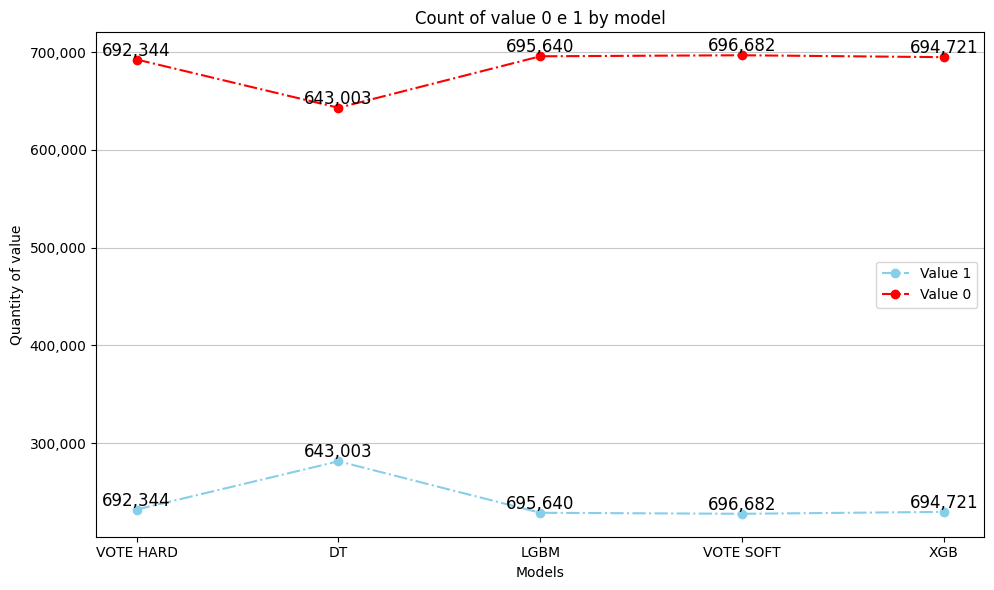

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(models, counts_1, marker='o', linestyle='-.', color='skyblue', label='Value 1')
plt.plot(models, counts_0, marker='o', linestyle='-.', color='red', label='Value 0')

for model, count1, count0 in zip(models, counts_1, counts_0):
    plt.text(model, count1, f'{count0:,.0f}', ha='center', va='bottom', fontsize=12)
    plt.text(model, count0, f'{count0:,.0f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Models')
plt.ylabel('Quantity of value')
plt.title('Count of value 0 e 1 by model')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


plt.show()


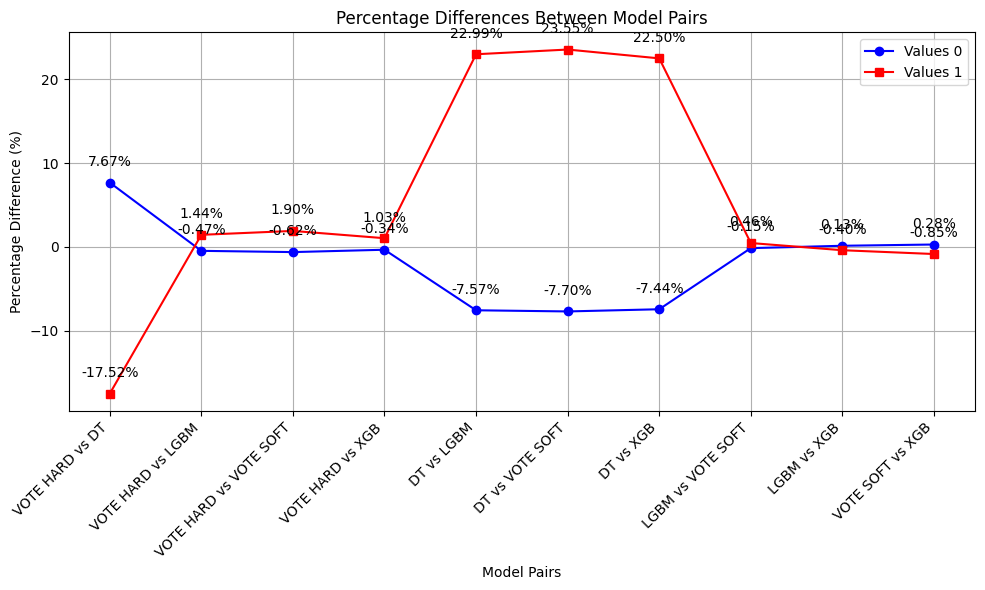

In [26]:
import numpy as np
diff_0 = []
diff_1 = []
labels = []

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        diff_percent_0 = ((counts_0[i] - counts_0[j]) / counts_0[j]) * 100
        diff_percent_1 = ((counts_1[i] - counts_1[j]) / counts_1[j]) * 100
        diff_0.append(diff_percent_0)
        diff_1.append(diff_percent_1)
        labels.append(f"{models[i]} vs {models[j]}")

fig, ax = plt.subplots(figsize=(10, 6))

line0, = ax.plot(labels, diff_0, marker='o', color='blue', label='Values 0')

line1, = ax.plot(labels, diff_1, marker='s', color='red', label='Values 1')

for i, (x, y) in enumerate(zip(labels, diff_0)):
    ax.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(0,12), ha='center')

for i, (x, y) in enumerate(zip(labels, diff_1)):
    ax.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(0,12), ha='center')

ax.set_title('Percentage Differences Between Model Pairs')
ax.set_xlabel('Model Pairs')
ax.set_ylabel('Percentage Difference (%)')

plt.xticks(rotation=45, ha='right')

# Adicionando legenda
ax.legend()

plt.tight_layout()
plt.grid(True)
plt.show()
